## Columns to be removed from training/validation

# Load Tensorflow and check GPU availability

In [3]:
import numpy as np
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F


import sys


from tensorflow.python.client import device_lib

for device in device_lib.list_local_devices():
    print(device.physical_device_desc)


    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


2025-01-27 16:44:20.398822: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-27 16:44:20.398853: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-27 16:44:20.428157: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-27 16:44:20.493018: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-27 16:44:21.545426: W tensorflow/compiler/tf2


device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


2025-01-27 16:44:25.588764: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-27 16:44:25.723624: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-27 16:44:25.725281: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# Load input datasets

In [4]:
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
from pandas import DataFrame
from pandas.core.dtypes import common as com
from pyarrow import Table


def union_tables(tables: [pa.Table]) -> pa.Table:
    union_table = tables[0]
    for table in tables[1:]:
        right_not_in_union = union_table.join(right_table=table, keys='domain_name', join_type='right anti',
                                              coalesce_keys=True, use_threads=True)
        union_table = pa.concat_tables([union_table, right_not_in_union])
    return union_table

# #############################################################
# EDIT this to specify benign / malicious datasets to use     #
# #############################################################
benign_dataset_filenames = [
    'parkets/benign_2312.parquet', 
]
malicious_dataset_filenames = [
    'parkets/phishing_2406_strict.parquet'
]
# #############################################################
# EDIT this for to set appropriate labels (malware, dga, ...) #
# #############################################################
benign_label = "benign"
malicious_label = "phishing"
# #############################################################

# Unify malicious datasets and benign datasets
schema = (pq.read_table(malicious_dataset_filenames[0])).schema # Use the schema from the first malicious filename
benign_tables = [pq.read_table(filename).cast(schema) for filename in benign_dataset_filenames]
malicious_tables = [pq.read_table(filename).cast(schema) for filename in malicious_dataset_filenames]
malicious = union_tables(malicious_tables)
benign = union_tables(benign_tables)

# Convert pyarrow tables to pandas dataframes
df_benign = benign.to_pandas()
df_malicious = malicious.to_pandas()

# Set appropriate labels
df_benign["label"] = benign_label
df_malicious["label"] = malicious_label
class_map = {benign_label: 0, malicious_label: 1}



# ===================
# AUTO BALANCING !!!
# Subsample benign to match the size of malicious
#df_benign = df_benign.sample(n=len(df_malicious))
# ===================

# Concatentate benign and malicious
df = pd.concat([df_benign, df_malicious])


def cast_timestamp(df: DataFrame):
    """
    Cast timestamp fields to seconds since epoch.
    """
    for col in df.columns:
        if com.is_timedelta64_dtype(df[col]):
            df[col] = df[col].dt.total_seconds()  # This converts timedelta to float (seconds)
        elif com.is_datetime64_any_dtype(df[col]):
            df[col] = df[col].astype(np.int64) // 10**9  # Converts datetime64 to Unix timestamp (seconds)

    return df

df = cast_timestamp(df)

# Handle NaNs
df.fillna(-1, inplace=True)


# SUBSAMPLE1 (OPTIONAL)
subsample = 0.05 # 1.0 means no subsample
if subsample < 1.0:
    df = df.sample(frac=subsample)

# Drop the domain name column
df.drop("domain_name", axis=1, inplace=True)

    
labels = df['label'].apply(lambda x: class_map[x]) # y vector
features = df.drop('label', axis=1).copy() # X matrix


print(f"Total features after augmentation: {features.shape[1]}")

print(f"Total samples: {len(df)}")
print(f"Benign count: {len(df_benign)}")
print(f"Malicious count: {len(df_malicious)}")



df

Total features after augmentation: 176
Total samples: 31331
Benign count: 462192
Malicious count: 164425


,label,dns_has_dnskey,dns_A_count,dns_AAAA_count,dns_MX_count,dns_NS_count,dns_TXT_count,dns_SOA_count,dns_CNAME_count,dns_zone_level,...,rdap_ip_v4_count,rdap_ip_v6_count,rdap_ip_shortest_v4_prefix_len,rdap_ip_longest_v4_prefix_len,rdap_ip_shortest_v6_prefix_len,rdap_ip_longest_v6_prefix_len,rdap_ip_avg_admin_name_len,rdap_ip_avg_admin_name_entropy,rdap_ip_avg_admin_email_len,rdap_ip_avg_admin_email_entropy
192399,benign,0.0,1,0,2,2,3,1,0,0,...,5,4,20.0,24.0,48.0,64.0,17.777778,0.209129,16.222222,0.185397
47565,benign,0.0,1,0,1,4,2,1,0,0,...,0,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
78561,benign,0.0,1,0,5,4,2,1,0,0,...,10,5,15.0,26.0,32.0,37.0,13.800000,0.249687,16.533333,0.147059
106319,benign,0.0,1,0,5,3,8,1,0,0,...,9,5,13.0,24.0,32.0,37.0,13.571429,0.257772,15.857143,0.118432
327138,benign,1.0,3,3,2,2,2,1,0,0,...,13,13,12.0,21.0,29.0,32.0,10.769231,0.350122,11.076923,0.121955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143315,phishing,0.0,1,1,0,0,1,0,0,1,...,1,1,23.0,23.0,36.0,36.0,5.000000,0.464386,15.000000,0.216015
203957,benign,0.0,1,0,5,4,1,1,0,0,...,9,9,15.0,24.0,37.0,48.0,13.578947,0.234503,5.894737,0.042578
331479,benign,0.0,1,0,0,0,0,0,0,0,...,1,0,23.0,23.0,0.0,0.0,14.000000,0.227286,21.000000,0.166630
71592,benign,0.0,1,0,2,2,1,1,0,1,...,5,0,12.0,30.0,0.0,0.0,20.000000,0.189068,22.400000,0.106346


In [5]:
from pycaret.utils import version
version()

from pycaret.classification import *
clf1 = setup(df, target = 'label', session_id=53, log_experiment=False, experiment_name='feta3', index=False, use_gpu = True)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more l

,Description,Value
0,Session id,53
1,Target,label
2,Target type,Binary
3,Target mapping,"benign: 0, phishing: 1"
4,Original data shape,"(32179, 177)"
5,Transformed data shape,"(32179, 177)"
6,Transformed train set shape,"(22525, 177)"
7,Transformed test set shape,"(9654, 177)"
8,Numeric features,173
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more l

In [6]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9589,0.9614,0.9589,0.9588,0.9588,0.8950,0.8951,0.9900
gbc,Gradient Boosting Classifier,0.9525,0.9637,0.9525,0.9522,0.9522,0.8780,0.8782,18.1990
xgboost,Extreme Gradient Boosting,0.9512,0.9614,0.9512,0.9511,0.9511,0.8755,0.8756,1.3230
rf,Random Forest Classifier,0.9420,0.9533,0.9420,0.9416,0.9417,0.8510,0.8513,1.1860
ada,Ada Boost Classifier,0.9401,0.9571,0.9401,0.9396,0.9396,0.8453,0.8459,3.7670
et,Extra Trees Classifier,0.9399,0.9067,0.9399,0.9395,0.9395,0.8451,0.8456,0.7220
lda,Linear Discriminant Analysis,0.9221,0.9513,0.9221,0.9216,0.9203,0.7934,0.7970,0.5480
ridge,Ridge Classifier,0.9210,0.9514,0.9210,0.9207,0.9188,0.7890,0.7937,0.2450
knn,K Neighbors Classifier,0.9132,0.9258,0.9132,0.9132,0.9131,0.7789,0.7791,0.3620
dt,Decision Tree Classifier,0.9036,0.8878,0.9036,0.9028,0.9031,0.7523,0.7526,1.7030


In [7]:
ada = create_model('ada')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9348,0.9508,0.9348,0.9341,0.9341,0.8306,0.8315
1,0.9445,0.9689,0.9445,0.9440,0.9440,0.8564,0.8571
2,0.9281,0.9463,0.9281,0.9272,0.9271,0.8123,0.8136
3,0.9414,0.9573,0.9414,0.9409,0.9408,0.8480,0.8488
4,0.9445,0.9587,0.9445,0.9440,0.9440,0.8563,0.8570
5,0.9352,0.9452,0.9352,0.9347,0.9349,0.8336,0.8338
6,0.9476,0.9698,0.9476,0.9472,0.9473,0.8651,0.8654
7,0.9445,0.9631,0.9445,0.9440,0.9439,0.8560,0.8568
8,0.9405,0.9531,0.9405,0.9400,0.9401,0.8467,0.8470


In [8]:
light_model = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9512,0.9560,0.9512,0.9509,0.9509,0.8747,0.8749
1,0.9667,0.9762,0.9667,0.9666,0.9666,0.9150,0.9151
2,0.9543,0.9529,0.9543,0.9540,0.9541,0.8830,0.8831
3,0.9623,0.9655,0.9623,0.9621,0.9621,0.9031,0.9033
4,0.9623,0.9604,0.9623,0.9621,0.9622,0.9036,0.9037
5,0.9494,0.9535,0.9494,0.9491,0.9492,0.8705,0.8706
6,0.9654,0.9680,0.9654,0.9652,0.9653,0.9115,0.9115
7,0.9658,0.9646,0.9658,0.9656,0.9656,0.9120,0.9123
8,0.9547,0.9562,0.9547,0.9545,0.9546,0.8841,0.8842


In [9]:
xboost_model = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9441,0.9552,0.9441,0.9438,0.9439,0.8569,0.8570
1,0.9578,0.9767,0.9578,0.9580,0.9579,0.8931,0.8931
2,0.9458,0.9534,0.9458,0.9455,0.9456,0.8613,0.8614
3,0.9569,0.9643,0.9569,0.9567,0.9568,0.8895,0.8897
4,0.9530,0.9627,0.9530,0.9527,0.9528,0.8796,0.8797
5,0.9414,0.9523,0.9414,0.9413,0.9413,0.8507,0.8507
6,0.9565,0.9671,0.9565,0.9564,0.9564,0.8891,0.8892
7,0.9560,0.9674,0.9560,0.9557,0.9557,0.8868,0.8871
8,0.9489,0.9531,0.9489,0.9488,0.9489,0.8698,0.8699


In [10]:
gbc = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9454,0.9584,0.9454,0.9450,0.9450,0.8593,0.8597
1,0.9618,0.9761,0.9618,0.9616,0.9617,0.9022,0.9023
2,0.9485,0.9543,0.9485,0.9481,0.9481,0.8671,0.8676
3,0.9512,0.9660,0.9512,0.9508,0.9509,0.8743,0.8746
4,0.9569,0.9647,0.9569,0.9567,0.9566,0.8887,0.8893
5,0.9427,0.9571,0.9427,0.9423,0.9424,0.8529,0.8531
6,0.9596,0.9729,0.9596,0.9594,0.9594,0.8965,0.8966
7,0.9591,0.9644,0.9591,0.9589,0.9589,0.8947,0.8951
8,0.9476,0.9600,0.9476,0.9472,0.9473,0.8655,0.8657


# TUNE MODELS

In [11]:
tune_model(gbc)
tune_model(light_model)
tune_model(xboost_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9476,0.9537,0.9476,0.9472,0.9472,0.8647,0.8652
1,0.9632,0.9720,0.9632,0.9630,0.9630,0.9055,0.9057
2,0.9490,0.9495,0.9490,0.9486,0.9486,0.8686,0.8689
3,0.9592,0.9659,0.9592,0.9589,0.9589,0.8946,0.8951
4,0.9601,0.9567,0.9601,0.9598,0.9599,0.8975,0.8976
5,0.9449,0.9525,0.9449,0.9445,0.9446,0.8585,0.8588
6,0.9631,0.9652,0.9631,0.9629,0.9630,0.9054,0.9056
7,0.9596,0.9642,0.9596,0.9595,0.9592,0.8951,0.8960
8,0.9543,0.9592,0.9543,0.9540,0.9540,0.8824,0.8827


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9530,0.9593,0.9530,0.9527,0.9527,0.8792,0.8794
1,0.9685,0.9750,0.9685,0.9684,0.9684,0.9195,0.9195
2,0.9538,0.9558,0.9538,0.9535,0.9536,0.8813,0.8815
3,0.9672,0.9655,0.9672,0.9670,0.9670,0.9156,0.9158
4,0.9614,0.9597,0.9614,0.9612,0.9612,0.9009,0.9011
5,0.9489,0.9560,0.9489,0.9488,0.9488,0.8697,0.8697
6,0.9671,0.9694,0.9671,0.9670,0.9671,0.9161,0.9162
7,0.9663,0.9658,0.9663,0.9661,0.9661,0.9134,0.9136
8,0.9591,0.9600,0.9591,0.9590,0.9590,0.8956,0.8957


Fitting 10 folds for each of 10 candidates, totalling 100 fits
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Info] Number of positive: 5453, number of negative: 14819
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 14398
[LightGBM] [Info] Number of data points in the train set: 20272, number of used features: 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9450,0.9570,0.9450,0.9447,0.9448,0.8593,0.8594
1,0.9592,0.9741,0.9592,0.9592,0.9592,0.8963,0.8963
2,0.9450,0.9524,0.9450,0.9446,0.9447,0.8589,0.8590
3,0.9596,0.9639,0.9596,0.9594,0.9594,0.8964,0.8965
4,0.9521,0.9557,0.9521,0.9520,0.9520,0.8778,0.8779
5,0.9436,0.9503,0.9436,0.9437,0.9436,0.8569,0.8569
6,0.9587,0.9647,0.9587,0.9587,0.9587,0.8950,0.8950
7,0.9556,0.9671,0.9556,0.9553,0.9554,0.8859,0.8862
8,0.9472,0.9561,0.9472,0.9469,0.9470,0.8648,0.8648


Fitting 10 folds for each of 10 candidates, totalling 100 fits


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              objective='binary:logistic', predictor=None, ...)

# Combine models

## Blended models 

In [12]:
blender = blend_models(estimator_list = [gbc, light_model, xboost_model], method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9534,0.9578,0.9534,0.9531,0.9532,0.8803,0.8805
1,0.9676,0.9773,0.9676,0.9675,0.9675,0.9173,0.9173
2,0.9538,0.9539,0.9538,0.9535,0.9536,0.8813,0.8815
3,0.9632,0.9663,0.9632,0.9630,0.9630,0.9054,0.9056
4,0.9623,0.9632,0.9623,0.9621,0.9621,0.9032,0.9034
5,0.9480,0.9562,0.9480,0.9478,0.9479,0.8670,0.8671
6,0.9658,0.9706,0.9658,0.9657,0.9657,0.9126,0.9126
7,0.9658,0.9651,0.9658,0.9656,0.9656,0.9121,0.9124
8,0.9560,0.9574,0.9560,0.9558,0.9559,0.8876,0.8877


## Boosted models

In [13]:
stacker = stack_models(estimator_list = [gbc,light_model,xboost_model], meta_model=ada)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9512,0.9593,0.9512,0.9509,0.9510,0.8749,0.8750
1,0.9672,0.9764,0.9672,0.9670,0.9671,0.9161,0.9162
2,0.9547,0.9536,0.9547,0.9545,0.9546,0.8842,0.8842
3,0.9623,0.9665,0.9623,0.9622,0.9622,0.9037,0.9037
4,0.9627,0.9620,0.9627,0.9625,0.9626,0.9046,0.9047
5,0.9512,0.9517,0.9512,0.9508,0.9509,0.8747,0.8748
6,0.9654,0.9684,0.9654,0.9652,0.9653,0.9114,0.9115
7,0.9663,0.9660,0.9663,0.9661,0.9661,0.9132,0.9135
8,0.9565,0.9629,0.9565,0.9562,0.9563,0.8884,0.8886


## Results

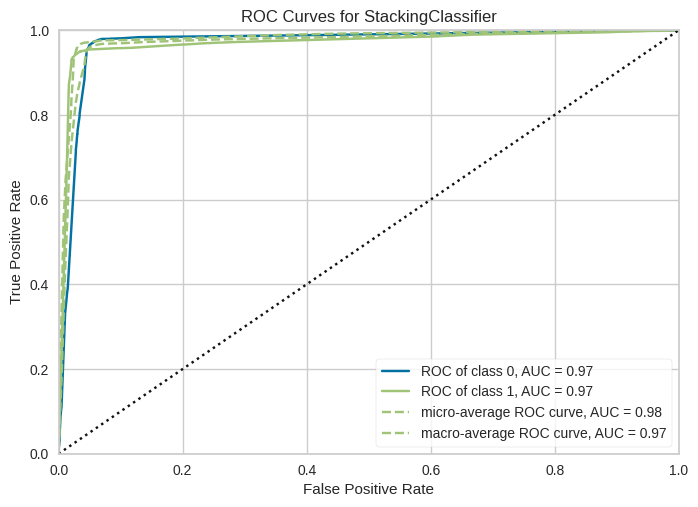

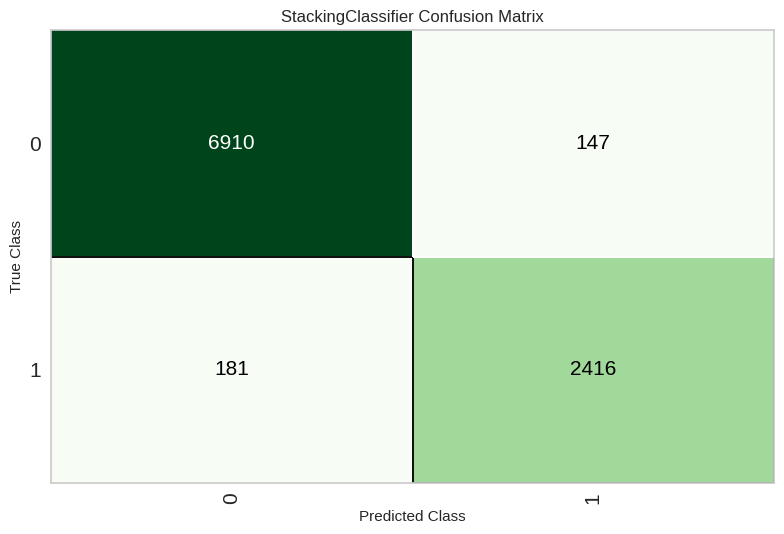

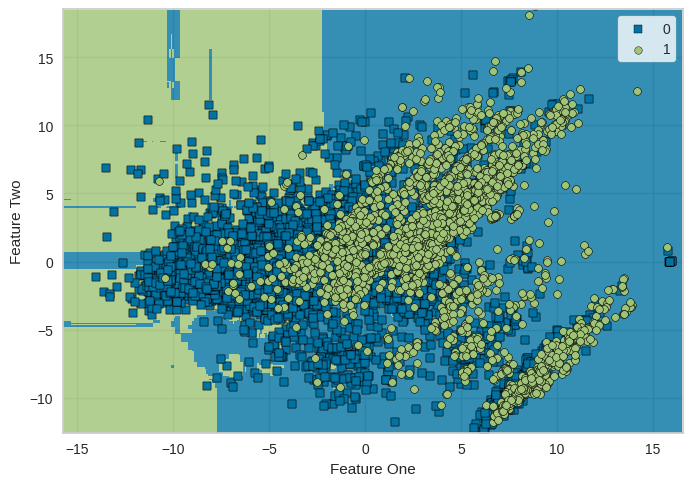

TypeError: This function only supports tree based models for binary classification: lightgbm, dt, rf, et, xgboost.

In [14]:
plot_model(stacker)
plot_model(stacker, plot = 'confusion_matrix')
plot_model(stacker, plot = 'boundary')
interpret_model(stacker)
interpret_model(blender)